# **SB3 model explainability with SHAP values**

First, we load the required libraries and specify the model and datasets paths.

In [39]:
import shap
import torch

import numpy as np

from pandas import read_csv

from stable_baselines3 import SAC

MODEL_PATH = './model.zip'
MONITOR_PATH = './monitor_norm.csv'
PROGRESS_PATH = './progress.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The SB3 agent is loaded. Every observation is composed by 82 floating point values, while actions are arrays of 6 values in `[-1,1]`.

In [40]:
agent = SAC.load(MODEL_PATH)

print(f'Observation space: {agent.observation_space}')
print(f'Action space: {agent.action_space}')

Observation space: Box(-50000000.0, 50000000.0, (82,), float32)
Action space: Box(-1.0, 1.0, (6,), float32)


We load the dataset and pre-visualize it.

In [41]:
monitor = read_csv(MONITOR_PATH)
monitor.head()

,timestep,month,day_of_month,hour,outdoor_temperature,outdoor_humidity,wind_speed,wind_direction,diffuse_solar_radiation,direct_solar_radiation,...,time (hours),reward,reward_energy_term,reward_comfort_term,absolute_energy_penalty,absolute_comfort_penalty,total_power_demand,total_temperature_violation,terminated,truncated
0,1,0.880037,-1.672148,-1.661309,1.799376,0.390650,0.789922,0.834005,-0.531274,-0.366595,...,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,2,0.880032,-1.672128,-1.661290,1.716155,0.554375,0.263325,1.096687,-0.531272,-0.366594,...,0.50,0.0,-0.0,0.0,-1482.128239,0.0,1482.128239,0.0,False,False
2,3,0.880027,-1.672109,-1.661271,1.632938,0.718100,-0.263271,1.359363,-0.531270,-0.366592,...,0.75,0.0,-0.0,0.0,-0.000000,0.0,0.000000,0.0,False,False
3,4,0.880022,-1.672089,-1.661252,1.549724,0.881823,-0.789866,-2.160616,-0.531268,-0.366591,...,1.00,0.0,-0.0,0.0,-0.000000,0.0,0.000000,0.0,False,False
4,5,0.880017,-1.672070,-1.516779,1.565658,0.881818,-0.756250,-2.160578,-0.531266,-0.366590,...,1.25,0.0,-0.0,0.0,-0.000000,0.0,0.000000,0.0,False,False


Those columns/variables not perceived by the agent during training are removed. Rows with `NaN` are also dropped.

In [42]:
to_remove = ['timestep', 'reward', 'reward_energy_term', 'reward_comfort_term', 'time (hours)',
             'absolute_energy_penalty', 'absolute_comfort_penalty', 'terminated',
             'truncated', 'total_temperature_violation', 'flow_livroom', 'total_power_demand',
             'flow_kitchen', 'flow_bed1', 'flow_bed2', 'flow_bed3', 'water_temperature']

data = monitor.drop(columns=to_remove).dropna()

data.head()

,month,day_of_month,hour,outdoor_temperature,outdoor_humidity,wind_speed,wind_direction,diffuse_solar_radiation,direct_solar_radiation,firstfloor:livingroom_htg_setpoint,...,secondfloor:bedroom02_floor_0_0_0_surface_internal_user_specified_location_temperature,secondfloor:bedroom03_floor_0_0_0_surface_internal_user_specified_location_temperature,firstfloor:livingroom_radiant_surface_flow_rate,firstfloor:kitchen_radiant_surface_flow_rate,secondfloor:bedroom01_radiant_surface_flow_rate,secondfloor:bedroom02_radiant_surface_flow_rate,secondfloor:bedroom03_radiant_surface_flow_rate,boiler_load_ratio,boiler_temperature,boiler_electricity_demand_rate
0,0.880037,-1.672148,-1.661309,1.799376,0.390650,0.789922,0.834005,-0.531274,-0.366595,0.000024,...,1.194756,0.576874,-1.186370,-1.087053,-1.480916,-1.576898,-2.273401,-0.754288,2.492204,-0.750742
1,0.880032,-1.672128,-1.661290,1.716155,0.554375,0.263325,1.096687,-0.531272,-0.366594,0.000024,...,1.162880,0.553299,-1.125241,-1.065635,-1.438151,-1.560716,-2.253462,-0.655345,2.492149,-0.655933
2,0.880027,-1.672109,-1.661271,1.632938,0.718100,-0.263271,1.359363,-0.531270,-0.366592,0.000024,...,1.128468,0.526189,-1.186353,-1.087039,-1.777963,-2.043049,-2.860248,-1.265649,-1.572040,-1.236037
3,0.880022,-1.672089,-1.661252,1.549724,0.881823,-0.789866,-2.160616,-0.531268,-0.366591,0.000024,...,1.086754,0.490908,-1.186344,-1.087031,-1.777941,-2.043016,-2.860167,-1.265639,-1.572023,-1.236027
4,0.880017,-1.672070,-1.516779,1.565658,0.881818,-0.756250,-2.160578,-0.531266,-0.366590,0.000024,...,1.041542,0.451432,-1.186336,-1.087024,-1.777918,-2.042984,-2.860087,-1.265629,-1.572007,-1.236017


Once the dataset and the model are both ready, we test them by doing some sample predictions.

In [43]:
def model_predict(data, model): 
    data_tensor = torch.tensor(data.values, dtype=torch.float32).to(device)
    with torch.no_grad():
        actions = model(data_tensor)
    return actions.cpu()

model_predict(data[:5], agent.policy)

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9993, -1.0000, -1.0000,  0.9998, -1.0000],
        [-1.0000, -0.9954, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9966, -0.9864, -1.0000, -0.9270, -1.0000]])

Now we will calculate the corresponding SHAP values. 

The `SACPolicyWrapper` class redefines the model, providing a single-vector output instead of a tuple.

We use a `KernelExplainer`, which is quite robust and model-agnostic.



In [44]:
SHAP_SAMPLES = 500

# def to_hash(action):
#     hashes = []
#     for a in action:
#         hashes.append(hash(tuple(a)))
#     return np.array(hashes)

class SACPolicyWrapper:
    def __init__(self, model):
        self.model = model
    
    def predict(self, obs):
        action, _ = self.model.predict(obs, deterministic=True)
        return action
        # return np.mean(action, axis=1) # mean
        # return np.linalg.norm(action, axis=1) # L2 norm
        # return to_hash(action)
    

policy_wrapper = SACPolicyWrapper(agent)

def sac_policy_predict(obs):
    return policy_wrapper.predict(obs)


X = data.sample(n=SHAP_SAMPLES, replace=False)

explainer = shap.KernelExplainer(sac_policy_predict, X)

shap_values = explainer.shap_values(X)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/500 [00:00<?, ?it/s]

Once the explainer is fit and the shap values are computed, we create an `Explanation` object and plot the results...

In [45]:
# explanation = shap.Explanation(
#     values=shap_values[:,:,1],
#     base_values=explainer.expected_value[1],
#     data=X,
#     feature_names=features
# )

# shap.plots.beeswarm(explanation.abs, max_display=len(features), color='shap_red')
# shap.plots.beeswarm(explanation.abs, color='shap_red')

# shap.plots.beeswarm(explanation, max_display=len(features))
# shap.plots.beeswarm(explanation)


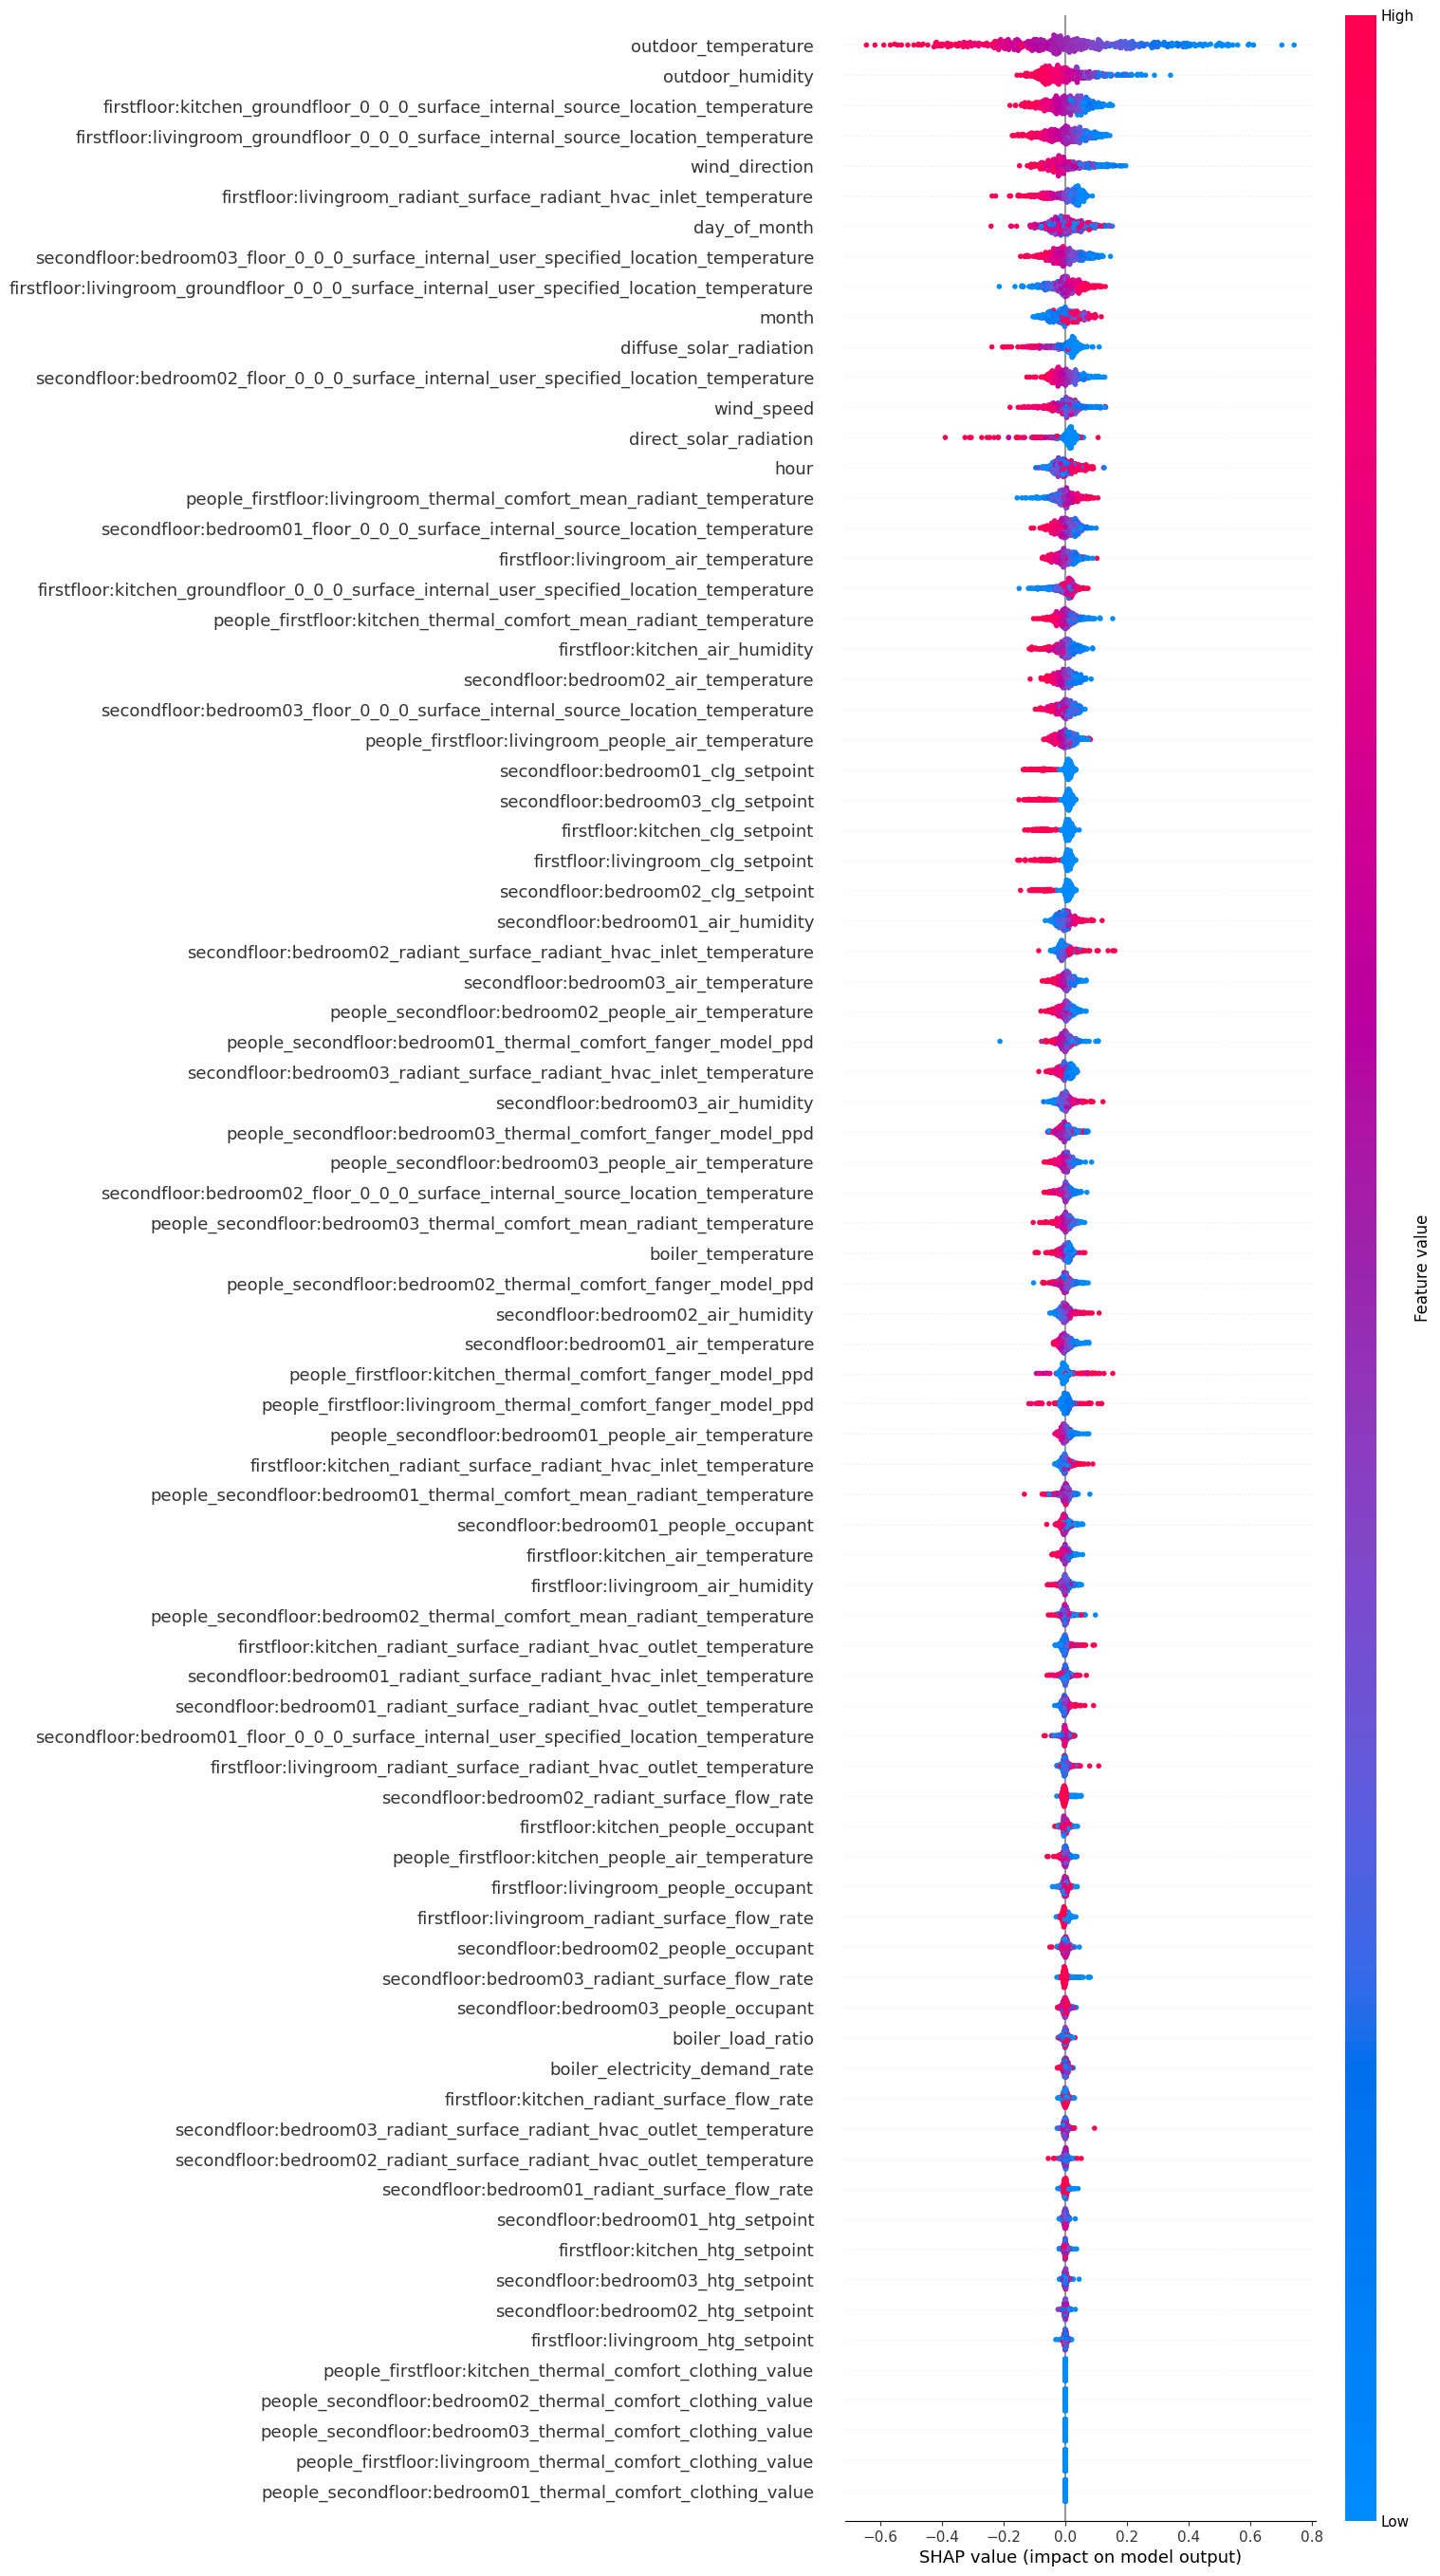

In [46]:
features = X.columns.tolist()

mean_shap_values = np.mean(shap_values, axis=2)

explanation = shap.Explanation(
    values=mean_shap_values,
    base_values=np.mean(explainer.expected_value),
    data=X,
    feature_names=features
)

shap.plots.beeswarm(explanation, max_display=len(features))
